# Securities portfolio modeling. Allocation, optimization and analysis
### Kirill Zakharov
telegram: @kirillzx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
import scipy.stats as sts
import yfinance as yf
from scipy.optimize import linprog
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import datetime
plt.style.use('ggplot')

In [9]:
class Portfolio:
    def __init__(self, names, dates):
        self.n = len(names)
        self.names = names
        self.data = pd.DataFrame()
        self.new_data = pd.DataFrame()
        self.w = np.array([1/self.n]*self.n)
        self.month_return = 0
        self.month_COV = 0
        self.month_risk = 0
        self.dates = dates

    def get_ts(self):
        self.data = pd.DataFrame(columns=self.names)
        for name in self.names:
            self.data[name] = yf.download(name, self.dates[0], self.dates[1])['Adj Close']

    def get_ts_csv(self):
        self.data = pd.read_csv('quotes.csv', sep='\t', parse_dates=True, index_col='Date')

    def graphics(self):
        if self.data.empty:
            print('At first, use get_ts() for download data')
        else:
            fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
            (self.data.pct_change()+1).cumprod().plot(ax=ax)
            plt.show()

    def resample_to_months(self):
        self.new_data = self.data.resample('M').last()

#     def get_month_return(self):
#         self.month_return = self.new_data.pct_change().mean()
#         return self.month_return

    def get_pct_change(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x))

    def get_month_return(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).mean()

#     def get_month_COV(self):
#         self.month_COV = self.new_data.pct_change().cov()
#         return self.month_COV

    def get_month_COV(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).cov()

    def get_month_risk(self, w):
        self.month_risk = np.dot(np.dot(w, self.get_month_COV()), w)
        return self.month_risk

    def get_returnP(self):
        return np.dot(self.w, self.get_month_return())

    def get_returnP_free(self, rf):
        return np.dot(self.w[:self.n], self.get_month_return()) + self.w[self.n] * rf

    def get_riskP(self):
        return np.dot(np.dot(self.w, self.get_month_COV()), self.w)

    def get_riskP_free(self):
        return np.dot(np.dot(self.w[:self.n], self.get_month_COV()), self.w[:self.n])

    def corr_matrix(self):
        fig = plt.figure(figsize=(8,6))
        cmap = sns.diverging_palette(220, 0, as_cmap=True)
        sns.heatmap(self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).corr(), cmap=cmap, annot = True, square=True)

        b1,t1=plt.ylim()
        b1+=0.5
        t1-=0.5
        plt.ylim(b1, t1)
        plt.show()
        
        
class OptimizationP(Portfolio):
    def __init__(self, names, dates):
        super().__init__(names, dates)
        self.bnds = tuple([(0.05, 0.15) for i in range(self.n)])
        self.init = np.repeat(0.05, self.n)
        self.cons = 0
        self.opt1 = 0
        # p = Portfolio(names, dates)
        self.free_cov_matrix = 0
        self.free_month_return = 0
        self.cov_matrix = 0
        self.return1 = 0
        self.dates = dates

    def get_help(self):
        print('maxReturn - maximize return of the portfolio\nminRisk - minimize risk of the portfolio',\
              '\nmaxSharpe - maximize a Sharpe ratio\nmaxSortino - maximize a Sortino ratio',\
             '\nminGenFun - minimize generalized function')

    def optimizeP(self, type_opt, boundsP, initP, rf=0.0037, t=0.5):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()

        if type_opt == 'maxReturn':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1},\
                        {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x))+0.01})

            self.opt1 = minimize(lambda x: -np.dot(x, self.return1), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x

            return self.opt1

        elif type_opt == 'minRisk':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
#                         {'type':'ineq', 'fun': lambda x: np.dot(self.return1, x)-0.02})

            self.opt1 = minimize(lambda x: np.dot(np.dot(x, self.cov_matrix), x), self.init,\
                                 method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x

            return self.opt1

        elif type_opt == 'maxSharpe':

            def sharpe_f(x):
                return -(np.dot(self.return1, x) - rf)/np.dot(np.dot(x, self.cov_matrix), x)

            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})

            self.opt1 = minimize(sharpe_f, self.init, method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x

            return self.opt1

        elif type_opt == 'maxSortino':
            r = self.return1
            array = []

#             for i in range(len(r)):
#                 if r[i] < rf:
#                     array.append(r[i])
#             r2 = 0

#             for i in range(len(array)):
#                 r2 += (array[i] - rf)**2
                
            array1 = []
            for i in range(len(r)):
                array1.append(min(r[i]-rf, 0)**2)
            

            def sortino_f(x):
#                 return -(np.dot(self.return1, x) - rf)/(r2/self.n)
                return -(np.dot(r, x) - rf)/(sum(array1)/len(r))

            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})

            self.opt1 = minimize(sortino_f, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x

            return self.opt1

        elif type_opt == 'minGenFun':

            def genFun(x):
                return -t * np.dot(self.return1, x) + np.dot(np.dot(x, self.cov_matrix), x)

            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})

            self.opt1 = minimize(genFun, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x

            return self.opt1

        elif type_opt == 'minGenFunFree':

            self.free_cov_matrix = np.vstack((np.hstack((self.cov_matrix, np.zeros((self.n,1)))), np.zeros(self.n+1)))
            self.free_month_return = np.append(self.return1, rf)

            def genFunFree(x):
                return -t * np.dot(self.free_month_return, x) + np.dot(np.dot(x, self.free_cov_matrix), x)

            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n+1)])
            self.init = np.repeat(initP, self.n+1)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n+1), x)-1})

            self.opt1 = minimize(genFunFree, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x

            return self.opt1

        else:
            return 'Choose the type of optimization. Use Object.get_help() to learn more.'

    def multi_criteria_opt(self, boundsP, initP, rf, t):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()

        f1 = -self.optimizeP('maxReturn', boundsP, initP, rf, t).fun
        f2 = -self.optimizeP('maxSharpe', boundsP, initP, rf, t).fun
        f3 = self.optimizeP('minGenFun', boundsP, initP, rf, t).fun

        r1 = np.append(self.return1, f1)
        r2 = np.append(self.return1, f2)
        r3 = np.append(self.return1, f3)

        def sharpe_f(x):
                return (np.dot(self.return1, x) - rf)/np.sqrt(np.dot(np.dot(x, self.cov_matrix), x))

        def genFun(x, t):
                return -t * np.dot(self.return1, x) + 0.5 * np.dot(np.dot(x, self.cov_matrix), x)

        def fun_x(x):
            array = np.zeros(self.n)
            array = np.append(array, 1)
            return np.dot(array, x)

        self.bnds = [(boundsP[0], boundsP[1]) for i in range(self.n)]
        self.bnds.append((0, 1))
        self.bnds = tuple(self.bnds)

        self.init = np.repeat(initP, self.n+1)
        self.cons = [{'type':'eq', 'fun': lambda x: np.dot(x[:self.n], np.ones(self.n))-1},
                    {'type':'ineq', 'fun': lambda x: np.array([-f1 + np.dot(x[:self.n], \
                                                                self.return1) + f1*x[self.n],
                                                              -f2 + sharpe_f(x[:self.n]) + f2*x[self.n]
                                                              -genFun(x[:self.n], t) + f3 + f3*x[self.n]])}]

        self.opt1 = minimize(lambda x: x[self.n], self.init, bounds=self.bnds, constraints=self.cons)
        self.w = self.opt1.x[:self.n]

        return self.opt1

    def optimal_t(self):
        l = np.ones(self.n)
        inv_COV = np.linalg.inv(self.get_month_COV())
        r = self.get_month_return()

        h0 = np.dot(l, inv_COV)/np.dot(np.dot(l, inv_COV), l)
        h1 = np.dot(inv_COV, r) - np.dot(inv_COV, l)*np.dot(np.dot(l, inv_COV), r)/np.dot(np.dot(l, inv_COV), l)

        alpha0 = np.dot(r, h0)
        alpha1 = np.dot(r, h1)
        beta0 = np.dot(np.dot(h0, self.get_month_COV()), h0)

        return (h0, h1, alpha0, alpha1, beta0)

    def efficient_frontier(self, boundsP, initP):
        temp = round(10000*self.optimizeP('minRisk', boundsP, initP).fun)
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()

        self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
        self.init = np.repeat(initP, self.n)

        eff_frontier = []

        for i in range(temp, 100):
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1},\
                        {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x)) + i/10000})
            opt = minimize(lambda x: -np.dot(self.return1, x), self.init,\
                                 bounds=self.bnds, constraints=self.cons)

            eff_frontier.append([i/100, round(-opt.fun*100, 3)])

        return np.array(eff_frontier).T

    def not_efficient_region(self, boundsP, initP):
        temp = round(10000*self.optimizeP('minRisk', boundsP, initP).fun)
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()

        self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
        self.init = np.repeat(initP, self.n)

        not_eff_reg = []

        for i in range(temp, 100):
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1},\
                        {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x)) + i/10000})
            opt = minimize(lambda x: np.dot(self.return1, x), self.init,\
                                 bounds=self.bnds, constraints=self.cons)

            not_eff_reg.append([i/100, opt.fun*100])

        return np.array(not_eff_reg).T

    
class Model:
    def __init__(self, type_opt, names, dates, m, rf, t, curr, budget, rb=False):
        self.type_opt = type_opt
        self.portfolio = OptimizationP(names, dates)
        self.rf = rf
        self.t = t
        self.costs = []
        self.res = []
        self.m = m
        self.curr = curr
        self.budget = budget
        self.forecast_data = []
        self.names = names
#         self.portfolio.get_ts()
        self.portfolio.get_ts_csv()
        self.portfolio.resample_to_months()
        self.income = []
        self.rb = rb
        self.cov_matrix = 0
        self.r = 0
        self.risk = 0.01
        self.fee_array = []
        self.fee = 0.03
        self.tax = 0.13

    def opt(self):
        if self.type_opt == 'multi-criteria':
            self.portfolio.multi_criteria_opt((0, 1), 0.01, self.rf, self.t)
        else:
            self.portfolio.optimizeP(self.type_opt, (0, 1), 0.01, self.rf)

        self.cov_matrix = self.portfolio.get_month_COV()
        self.risk = np.dot(self.portfolio.w[:self.portfolio.n], \
                           np.dot(self.cov_matrix, self.portfolio.w[:self.portfolio.n]))
        self.r = np.dot(self.portfolio.w[:self.portfolio.n], self.portfolio.get_month_return())

    def buy(self): #get quantity of assets at moment t0
        self.opt()
        self.costs = []
        self.res = []
        self.costs = np.array(self.portfolio.data.iloc[-1])

        u = np.dot(self.portfolio.w, self.budget)

        for i in range(self.m):
            self.res.append(u[i] / self.costs[i])
            self.fee_array.append((self.fee*self.costs[i])*(u[i] / self.costs[i]))

        for i in range(self.m, self.portfolio.n):
            self.res.append(u[i] / (self.curr[-1]*self.costs[i]))

        return self.res

    def quant(self):
        temp = self.buy()
        return f'Quantity {self.type_opt}: {[round(i) for i in temp]}'

    def forecast(self):
        self.forecast_data = []
        for name in self.names:
            model = ARIMA(self.portfolio.new_data[name], order=(1,2,1), freq='M')
            model_fit = model.fit()
            forecast = model_fit.forecast(5)
            self.forecast_data.append(np.array(forecast))

        self.forecast_data = np.array(self.forecast_data)
        return self.forecast_data

    def portfolio_return(self):
        self.forecast()
        if self.rb:
            total_income = self.budget
            b = self.budget
            self.rb_data = self.portfolio.data
            for j in range(len(self.forecast_data[0])):
                self.portfolio.data.loc[f'pr{j}'] = self.forecast_data.T[j]
                self.budget = total_income
                self.income = []
                s = self.buy()
                for i in range(self.m):
                    self.income.append(self.forecast_data[i, j]*s[i] +\
                                   s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))

                for i in range(self.m, self.portfolio.n):
                    self.income.append(self.forecast_data[i, j]*self.curr[-1]*s[i] +\
                                       s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))
                total_income = sum(self.income)
            return total_income - b

        elif not self.rb:
            self.income = []
            s = self.buy()

            for i in range(self.m):
                self.income.append(self.forecast_data[i, -1]*s[i] +\
                                   s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))
                self.fee_array[i] = self.fee_array[i] + (self.fee*self.forecast_data[i, -1]*s[i])

            for i in range(self.m, self.portfolio.n):
                self.income.append(self.forecast_data[i, -1]*self.curr[-1]*s[i] +\
                                   s[i]*self.costs[i]*np.random.normal(loc=self.r, scale=np.sqrt(self.risk)))

            return sum(self.income) - self.budget - sum(self.fee_array) - (sum(self.income) - self.budget)*self.tax

        else:
            print('Specify True or False rebalance!')

In [22]:
class PortfolioModel(OptimizationP):
    def __init__(self, names, dates, bounds, init, rf, t):
        super().__init__(names, dates)
        self.bounds = bounds
        self.initP = init
        self.rf = rf
        self.t = t
        
        self.get_ts_csv()
#         self.get_ts()
        self.resample_to_months()        
        
    def all_opt(self):
        p_return = self.get_month_return()
        p_cov = self.get_month_COV()
        
        self.max_return = self.optimizeP('maxReturn', (self.bounds[0], self.bounds[1]), self.initP, self.rf)
        self.max_return_ret = round(np.dot(p_return, self.max_return.x), 3)*100
        self.max_return_risk = round(np.dot(self.max_return.x, np.dot(p_cov, self.max_return.x)), 3)*100
        
        self.max_sharpe = self.optimizeP('maxSharpe', (self.bounds[0], self.bounds[1]), self.initP, self.rf)
        self.max_sharpe_ret = round(np.dot(p_return, self.max_sharpe.x)*100, 3)
        self.max_sharpe_risk = round(np.dot(np.dot(self.max_sharpe.x, p_cov), self.max_sharpe.x)*100, 3)
        self.max_sharpe_ratio = -self.max_sharpe.fun
        
        self.max_sortino = self.optimizeP('maxSortino', (self.bounds[0], self.bounds[1]), self.initP, self.rf)
        self.max_sort_ret = round(np.dot(p_return, self.max_sortino.x)*100, 3)
        self.max_sort_risk = round(np.dot(np.dot(self.max_sortino.x, p_cov), self.max_sortino.x)*100, 3)
        
        self.min_risk = self.optimizeP('minRisk', (self.bounds[0], self.bounds[1]), self.initP, self.rf)
        self.min_risk_ret = round(np.dot(p_return, self.min_risk.x)*100, 3)
        self.min_risk_risk = round(np.dot(np.dot(self.min_risk.x, p_cov), self.min_risk.x)*100, 3)
        
        self.gen_func = self.optimizeP('minGenFun', (self.bounds[0], self.bounds[1]), self.initP, self.rf, self.t)
        self.gen_func_ret = round(np.dot(p_return, self.gen_func.x)*100, 3)
        self.gen_func_risk = round(np.dot(np.dot(self.gen_func.x, p_cov), self.gen_func.x)*100, 3)
        
        self.genfunfree = self.optimizeP('minGenFunFree', (self.bounds[0], self.bounds[1]), self.initP, self.rf,\
                                                      self.t)
        self.genfunfree_ret = round(np.dot(p_return, self.genfunfree.x[:-1])*100 + 100*rf*self.genfunfree.x[-1], 3)
        self.genfunfree_risk = round(np.dot(np.dot(self.genfunfree.x[:-1], p_cov), self.genfunfree.x[:-1])*100, 3)
        
        self.mc = self.multi_criteria_opt((self.bounds[0], self.bounds[1]), self.initP, self.rf, self.t)
        self.mc_ret = round(np.dot(p_return, self.mc.x[:-1])*100, 3)
        self.mc_risk = round(np.dot(np.dot(self.mc.x[:-1], p_cov), self.mc.x[:-1])*100, 3)
        
        return print('>>> All optimization tasks have been successfully solved')
        
    def randomP(self, num):
        p_return = self.get_month_return()
        p_cov = self.get_month_COV()
        
        num_portf = num
        p_r = []
        p_std = []
        p_w = []
        self.sharpe_ratio = []

        for i in range(num_portf):
            w = np.random.uniform(0, 1, n)
            w = w/np.sum(w)
        #     w = np.random.dirichlet(np.ones(n)*100,size=1)[0]
            p_w.append(w)

            returns = np.dot(w, p_return)
            p_r.append(round(100*returns, 3))

            std = np.dot(np.dot(w, p_cov), w)
            p_std.append(round(100*std, 3))

            self.sharpe_ratio.append((returns - rf)/std)
            
        array = {'Returns':p_r, 'Risks':p_std}

        for i, stock in enumerate(names):
            array[stock] = [w[i] for w in p_w]

        self.portfolios = pd.DataFrame(array)
        self.sharpe = self.portfolios.iloc[((self.portfolios['Returns']-self.rf)/self.portfolios['Risks']).argmax()]
        
        return print('>>> Random portfolios were successfully generated')
        
    def efficientFrontier(self):
        
        def CML(x, r, var):
            return rf + x*(r-rf)/var

        eff_frontier = self.efficient_frontier((self.bounds[0], self.bounds[1]), self.initP)
        not_eff_reg = self.not_efficient_region((self.bounds[0], self.bounds[1]), self.initP)
        x = np.linspace(self.min_risk_risk/2, (self.max_return_risk)/2+0.2, 50)
        
        fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

        plt.scatter(eff_frontier[0], eff_frontier[1], c='black', zorder=2, s=8, label='Efficient frontier')
        plt.scatter(not_eff_reg[0], not_eff_reg[1], c='#365aad', zorder=2, s=8, label='Not efficient region')

        plt.scatter(self.portfolios['Risks'], self.portfolios['Returns'], s=15, alpha=0.6,\
                    c=self.sharpe_ratio, cmap='plasma')
        plt.colorbar(label = 'Sharpe Ratio')

        plt.plot(x, CML(x, self.max_sharpe_ret, self.max_sharpe_risk), linewidth=1, c='purple', \
                   label='The Capital Market Line', zorder=2) #the CML

        plt.scatter(self.sharpe['Risks'], self.sharpe['Returns'], s=30, c='#32CD32', marker='D', \
                    edgecolor='black', label='Max-random-SR portfolio', zorder=3)#Random best sharpe ratio (0, 1)

        plt.scatter(self.max_sharpe_risk, self.max_sharpe_ret, s=30, c='#ff8000', edgecolor='black', \
                   label='Max-SR portfolio', marker='D', zorder=3) #sharpe ratio (0, 1)

        plt.scatter(self.min_risk_risk, self.min_risk_ret, s=40, c='#02a4d3', edgecolor='black', \
                   label='Min-variance portfolio', zorder=3) #min risk (0, 1)

        plt.scatter(self.max_return_risk, self.max_return_ret, s=40, c='r', edgecolor='black', \
                   label='Max-return portfolio', zorder=3) #max return (0, 1)

        plt.scatter(self.max_sort_risk, self.max_sort_ret, s=60, c='r', edgecolor='black', \
                   label='Max-Sortino portfolio', marker='*', zorder=3) #max Sortino ratio (0, 1)

        plt.scatter(self.gen_func_risk, self.gen_func_ret, s=50, c='#effd17', edgecolor='black', \
                   label='Generalized fun', marker='^', zorder=3) #gen func

        plt.scatter(self.genfunfree_risk, self.genfunfree_ret, s=50, c='#fa8800', edgecolor='black', \
                   label='Gen. free fun', marker='^', zorder=3) #gen func free

        plt.scatter(self.mc_risk, self.mc_ret, s=40, c='#30d5c8', edgecolor='black', \
                   label='Multi-criteria', marker='s', zorder=3) #multi-criteria

        plt.xlabel('Risk, %')
        plt.ylabel('Return, %')
        # plt.xlim(min_risk_risk-0.02, max_return_risk+0.02)
        # plt.ylim(-1, 10)
        plt.legend(loc=2, prop={'size': 8})
        plt.show()
        
    def indicators(self, MP):
        n = len(names)
        #download market portfolio
        market_portfolio = yf.download(MP, dates[0], dates[1])['Adj Close']
        
        mp_pct_change = market_portfolio.resample('M').last().pct_change(1).apply(lambda x: np.log(1+x))
        mp_mean = mp_pct_change.mean()
        mp_var = mp_pct_change.var()
#         print(f'Market portfolio mean: {round(mp_mean*100, 3)} %\nMarket portfolio variance: {round(mp_var*100, 3)} %')

        all_ind_ret = np.array([self.max_return_ret, self.max_sharpe_ret, self.max_sort_ret, self.min_risk_ret,\
                                self.gen_func_ret, self.genfunfree_ret, self.mc_ret])
        all_ind_risk = np.array([self.max_return_risk, self.max_sharpe_risk, self.max_sort_risk, self.min_risk_risk,\
                                 self.gen_func_risk, self.genfunfree_risk, self.mc_risk])
        all_w = np.array([self.max_return.x, self.max_sharpe.x, self.max_sortino.x, \
                          self.min_risk.x, self.gen_func.x, self.genfunfree.x[:n], self.mc.x[:n]])
        
        pct_change = self.get_pct_change()
        month_return = self.get_month_return()
        beta_ind = []
        
        #calc beta ratio
        for i in range(n):
            beta_ind.append(((mp_pct_change.values[1:] * pct_change.iloc[1:, i].values).mean()-mp_mean*month_return[i])/mp_var)

        all_beta = []

        for i in range(len(all_w)):
            all_beta.append(np.dot(np.array(beta_ind), all_w[i]))
            
        #calc M2 ratio
        m2 = (all_ind_ret - self.rf)*(mp_var/all_ind_risk) + self.rf
            
        indicators = np.array([list(map(lambda x: str(round(x, 3))+'%', all_ind_ret)),\
                       list(map(lambda x: str(round(x, 3))+'%', all_ind_risk)),\
                       np.around(np.array(all_ind_ret/all_ind_risk), 3), np.around(all_beta, 3),\
                       np.around((all_ind_ret-rf)/all_beta, 3), np.around(m2, 3)])
        columns = ['Max return', 'Max Sharpe ratio', 'Max Sortino ratio', 'Min risk', 'Generalized fun',\
                   'Generalized free fun', 'Multi-criteria']
        index = ['Return', 'Risk', 'Return/Risk', 'Beta', 'Treynor ratio', 'M2']

        indicators_df = pd.DataFrame(indicators, columns=columns, index=index)
        return indicators_df
    
    def modeling(self, m, budget, curr, rb, names_opt):
        total_return = []
        quantities = []
        
        for name in names_opt:
            model = Model(name, self.names, self.dates, m, self.rf, self.t, curr, budget, rb)
            total_return.append(model.portfolio_return())
            quantities.append(model.quant())
            
        for i, name in enumerate(names_opt):
            print(f'{name}: {round(total_return[i], 3)}')  

## Initialize model

In [23]:
rf = 0.0037
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
# names = ['AAPL', 'AMZN', 'IBM', 'SBER.ME']
dates = ('2018-01-01', '2021-02-01')
n = len(names)
bounds = (0, 1)
init = 0.01
rf = 0.0037
t = 0.4

portfolio = PortfolioModel(names, dates, bounds, init, rf, t)

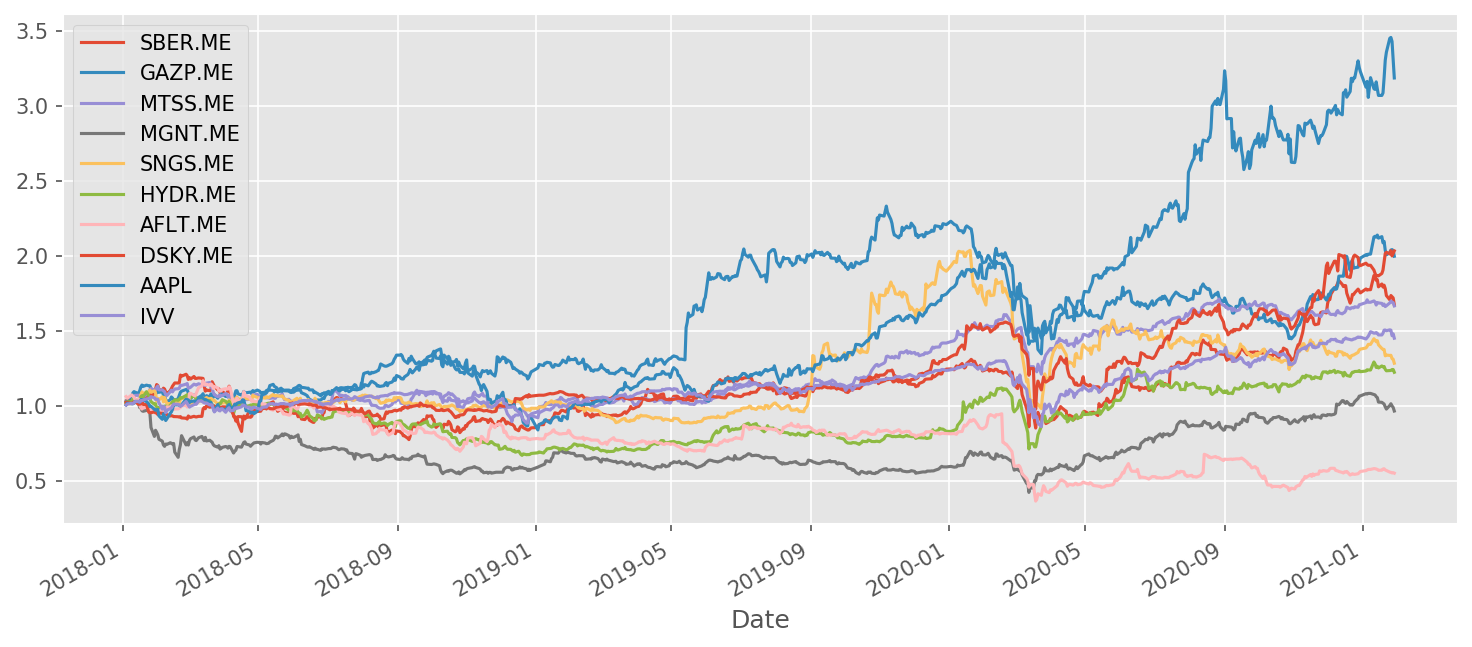

In [24]:
portfolio.graphics()

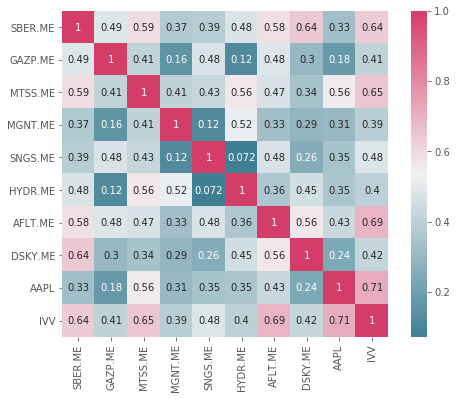

In [13]:
portfolio.corr_matrix()

In [25]:
portfolio.all_opt() #solve optimization tasks
portfolio.randomP(1000) #Generate 1000 random portfolios

>>> All optimization tasks have been successfully solved
>>> Random portfolios were successfully generated


## Efficient frontier

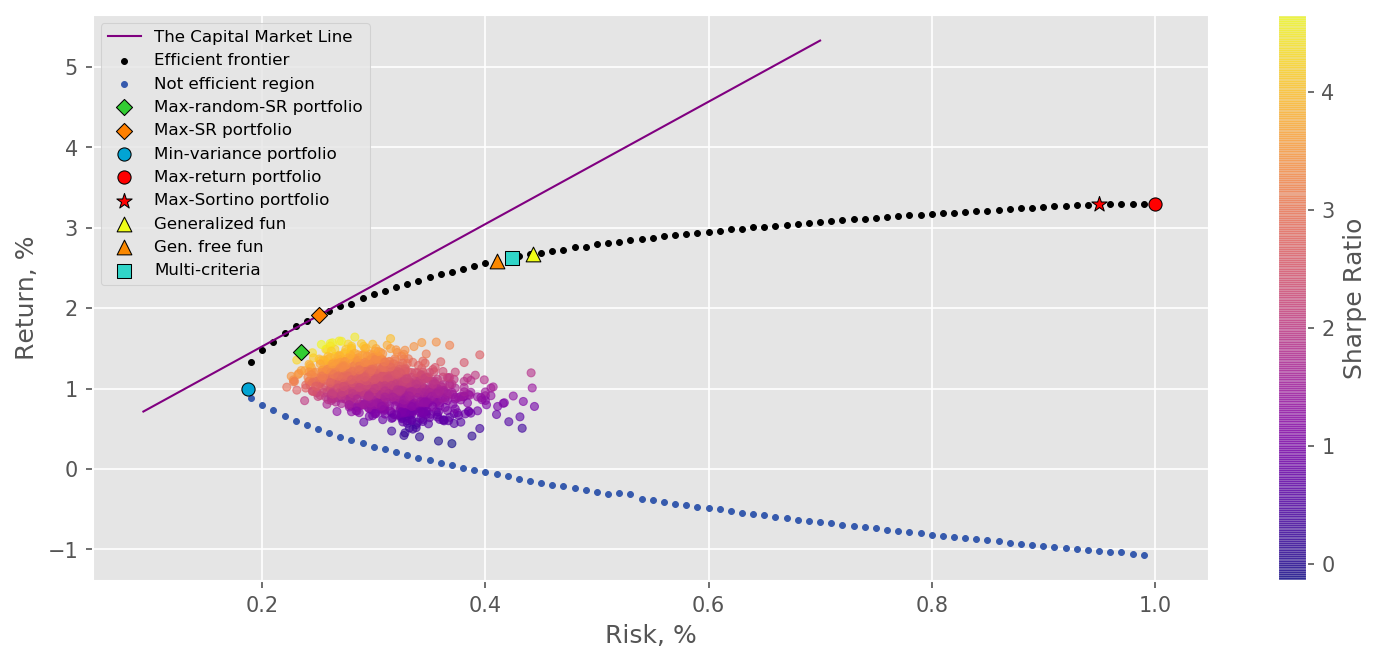

In [26]:
portfolio.efficientFrontier()

## Indicators

In [27]:
market_portfolio = 'SPY'
portfolio.indicators(market_portfolio)

[*********************100%***********************]  1 of 1 completed


,Max return,Max Sharpe ratio,Max Sortino ratio,Min risk,Generalized fun,Generalized free fun,Multi-criteria
Return,3.3%,1.913%,3.296%,0.993%,2.676%,2.585%,2.63%
Risk,1.0%,0.251%,0.95%,0.187%,0.443%,0.41%,0.424%
Return/Risk,3.3,7.622,3.469,5.31,6.041,6.305,6.203
Beta,1.263,0.714,1.263,0.636,0.951,0.916,0.927
Treynor ratio,2.61,2.672,2.606,1.556,2.811,2.819,2.834
M2,0.013,0.026,0.014,0.019,0.021,0.022,0.022


## Simulation

In [72]:
m = 8
budget = 1000000
rb = False
names_opt = ('maxReturn', 'minRisk', 'maxSharpe', 'maxSortino', 'minGenFun', 'minGenFunFree', 'multi-criteria')
curr = yf.download('RUB=X', dates[1], datetime.date.today())['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [73]:
portfolio.modeling(m, budget, curr, rb, names_opt)

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


maxReturn: 87229.496
minRisk: -991.606
maxSharpe: 44308.25
maxSortino: 86687.83
minGenFun: 84472.291
minGenFunFree: 92180.501
multi-criteria: 86274.0
